## Single Core Training AlexNet on Fashion MNIST 

* 参考 https://colab.research.google.com/github/pytorch/xla/blob/master/contrib/colab/single-core-alexnet-fashion-mnist.ipynb

我们在[Fashion MNIST dataset](https://github.com/zalandoresearch/fashion-mnist)数据集上，使用PyTorch训练一个 [AlexNet](https://arxiv.org/abs/1404.5997)网络，注意我们只使用一个Cloud TPU 核（core）。




### 数据集 & AlexNet

Fashion MNIST数据集和AlexNet都被包含在 [Torchvision package](https://pytorch.org/docs/stable/torchvision/index.html)。

我们先介绍下 Fashion MNIST 数据集，这是一个10分类的图片分类任务。

In [1]:
# Downloads the Fashion MNIST dataset using Torchvision
# Note: This may take a minute.
import os
import torch
import torchvision
import torchvision.datasets as datasets

# Maps integer class index to human-readable string describing the class
class_map = {
0 : "t-shirt",
1 : "trouser",
2 : "pullover",
3 : "dress",
4 : "coat",
5 : "sandal",
6 : "shirt",
7 : "sneaker",
8 : "bag",
9 : "ankle boot"
}

# Downloads the Fashion MNIST dataset using Torchvision
raw_dataset = datasets.FashionMNIST(
    os.path.join("/tmp/fashionmnist"),
    train=True,
    download=True)

`raw_dataset`中元素类型是tuple，分别是图片和对应的类别。

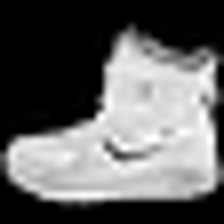

ankle boot


In [2]:
img_index = 0
tup = raw_dataset[img_index]
display(tup[0].resize((224, 224)))
print(class_map[tup[1]])

再来创建一个AlexNet，将其放到Cloud TPU核中。

In [3]:
import torch_xla
import torch_xla.core.xla_model as xm


# Creates AlexNet for 10 classes
net = torchvision.models.alexnet(num_classes=10)

# Acquires the default Cloud TPU core and moves the model to it
device = xm.xla_device()
net = net.to(device)

In [4]:
print(net)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

### Dataloaders

数据集和网络已经准备好了，下面就是读取数据了，


In [5]:
import torchvision.transforms as transforms

# See https://pytorch.org/docs/stable/torchvision/models.html for normalization
# Pre-trained TorchVision models expect RGB (3 x H x W) images
# H and W should be >= 224
# Loaded into [0, 1] and normalized as follows:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
to_rgb = transforms.Lambda(lambda image: image.convert('RGB'))
resize = transforms.Resize((224, 224))
my_transform = transforms.Compose([resize, to_rgb, transforms.ToTensor(), normalize])

In [6]:
train_dataset = datasets.FashionMNIST(
    os.path.join("/tmp/fashionmnist"),
    train=True,
    download=True,
    transform=my_transform)

test_dataset = datasets.FashionMNIST(
    os.path.join("/tmp/fashionmnist"),
    train=False,
    download=True,
    transform=my_transform)

In [7]:
train_sampler = torch.utils.data.RandomSampler(train_dataset)
test_sampler = torch.utils.data.RandomSampler(test_dataset)

In [8]:
batch_size = 8

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    sampler=test_sampler)

In [9]:
import time
# from google.colab import widgets

t_to_img = transforms.Compose([transforms.ToPILImage(), transforms.Grayscale()])

# Runs the given net on the batches provided by the test_loader
# Records the number of correct predictions (guesses) and 
# prints the percentage of correct guesses on the dataset, plus a 
# sample batch.
def eval_network(net, test_loader):
    start_time = time.time()
    num_correct = 0
    total_guesses = 0

    # Sets eval and no grad context for evaluation
    net.eval()
    with torch.no_grad():
        for data, targets in iter(test_loader):
            # Sends data and targets to device
            data = data.to(device)
            targets = targets.to(device)

            # Acquires the network's best guesses at each class
            results = net(data)
            best_guesses = torch.argmax(results, 1)

            # Updates number of correct and total guesses
            num_correct += torch.eq(targets, best_guesses).sum().item()
            total_guesses += batch_size
    
        # Prints output
        elapsed_time = time.time() - start_time
        print("Correctly guessed ", num_correct/total_guesses*100, "% of the dataset")
        print("Evaluated in ", elapsed_time, " seconds")
        print("Sample batch:")
        
        for ex in zip(data, targets, best_guesses):
            data = ex[0].cpu()
            target = class_map[ex[1].item()]
            guess = class_map[ex[2].item()]

            img = t_to_img(data)
            display(img)
            print("Target: ", target)
            print("Guess: ", guess)

Correctly guessed  10.0 % of the dataset
Evaluated in  24.265239238739014  seconds
Sample batch:


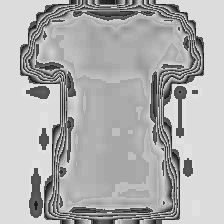

Target:  t-shirt
Guess:  pullover


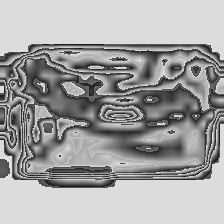

Target:  bag
Guess:  pullover


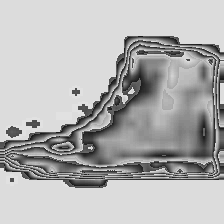

Target:  ankle boot
Guess:  pullover


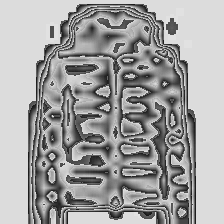

Target:  coat
Guess:  pullover


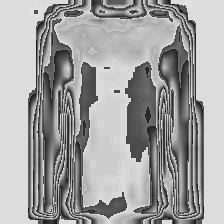

Target:  pullover
Guess:  pullover


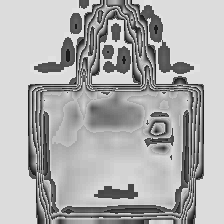

Target:  bag
Guess:  pullover


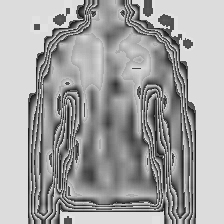

Target:  coat
Guess:  pullover


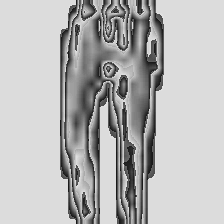

Target:  trouser
Guess:  pullover


In [10]:
# Percentage of guesses that are correct (expected to be 0.1)
eval_network(net, test_loader)

现在网络还没有训练，就是瞎猜，大概能猜对10%

### 训练神经网络

这里都是PyTorch的套路:

- enumerates a dataset in batches
- runs the network on each batch
- evaluates the network's performance using a loss function
- calls `backward()` to propagate gradients through the network
- uses an optimizer to `step()` and apply the gradients to the network's weights

可以看到，只有一点特殊，那就是要用XLA进行梯度更新，`xm.optimizer_step(optimizer, barrier=True)`

In [11]:
# Note: this will take 5-10 minutes to run.
num_epochs = 1  # 为了节省时间，我们只训练一个epoch
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters())

# Ensures network is in train mode
net.train()

start_time = time.time()
step_idx = 0
for epoch in range(num_epochs):
    for data, targets in iter(train_loader):
        # Sends data and targets to device
        data = data.to(device)
        targets = targets.to(device)

        # Acquires the network's best guesses at each class
        results = net(data)

        # Computes loss
        loss = loss_fn(results, targets)
        if step_idx % 100 == 0:
            print(loss.detach().item())
        # Updates model
        optimizer.zero_grad()
        loss.backward()
        xm.optimizer_step(optimizer, barrier=True)  # 注意：这里需要用XLA

elapsed_time = time.time() - start_time
print ("Spent ", elapsed_time, " seconds training for ", num_epochs, " epoch(s) on a single core.")

2.3031206130981445
7.2170867919921875
2.309246063232422
2.2534289360046387
2.2400450706481934
2.5558505058288574
2.324819564819336
2.507387399673462
2.303727865219116
2.3412704467773438
2.3234221935272217
2.2940378189086914
2.310166358947754
2.320793867111206
2.277737855911255
2.2630183696746826
2.256646156311035
2.288088321685791
2.175987720489502
2.591337203979492
2.381892442703247
2.199685573577881
2.2788290977478027
2.3840653896331787
2.2961955070495605
2.307647943496704
2.296388626098633
2.260962963104248
2.3261990547180176
2.2856602668762207
2.3413281440734863
2.250694990158081
2.2649199962615967
2.3078861236572266
2.2748947143554688
2.272770643234253
2.3346810340881348
2.2617945671081543
2.2765588760375977
2.2969095706939697
2.2747368812561035
2.2896671295166016
2.334418773651123
2.193019390106201
2.439176559448242
2.2698705196380615
2.3957784175872803
2.275786876678467
2.2911641597747803
2.214606285095215
2.2583816051483154
2.4702465534210205
2.4024534225463867
2.30354642868042

0.5139832496643066
0.9546505808830261
2.5467586517333984
0.7728255987167358
1.2429903745651245
0.7039569020271301
1.5241382122039795
1.5730184316635132
2.6796939373016357
1.5360643863677979
1.0581233501434326
1.138047695159912
1.7708306312561035
0.8429454565048218
1.1523749828338623
1.1796067953109741
0.4507484436035156
0.7767786979675293
0.5624597668647766
1.580366611480713
0.8695585131645203
0.34938812255859375
1.000392198562622
0.43528813123703003
1.1394087076187134
0.8137680292129517
1.092375636100769
1.0921862125396729
0.5890867710113525
0.4960757791996002
0.37784403562545776
1.2117475271224976
1.285403847694397
0.6148922443389893
3.0995967388153076
0.669306755065918
1.7141952514648438
1.1939269304275513
1.16623055934906
0.9636187553405762
0.9633798003196716
0.6273209452629089
0.6310391426086426
1.2182509899139404
1.001158595085144
1.1950618028640747
0.5608462691307068
1.4634332656860352
0.13362382352352142
1.189623236656189
1.2470158338546753
0.9030713438987732
1.0726616382598877

0.30968713760375977
1.2259745597839355
0.5040721893310547
0.8330608606338501
0.6646233201026917
0.7069724798202515
0.3697434961795807
0.38783618807792664
0.7372719645500183
0.48294198513031006
0.248591348528862
2.150052070617676
0.6376943588256836
0.6904913187026978
0.630013644695282
1.4647769927978516
0.8063597679138184
0.23927141726016998
0.882127583026886
0.515508770942688
0.4932127296924591
0.4729141592979431
1.237128734588623
0.8523355722427368
0.8386370539665222
0.5081076622009277
0.4125592112541199
0.774224579334259
0.8023608922958374
0.9279682040214539
0.7980971932411194
0.9380070567131042
0.6848225593566895
0.6708081364631653
0.18079011142253876
0.5404555201530457
0.7484462857246399
1.1314892768859863
0.902107298374176
0.7560253143310547
0.43131381273269653
0.5916138291358948
0.650719940662384
0.7247974872589111
1.7683881521224976
0.7445645332336426
0.4952041804790497
0.49148479104042053
0.933127224445343
0.45833393931388855
1.1643123626708984
1.13407301902771
0.35590258240699

0.4764404892921448
0.19289162755012512
1.3906350135803223
1.1782863140106201
0.8581011295318604
0.658650815486908
1.4656327962875366
0.5094559788703918
0.5394908785820007
0.6336212158203125
0.9459148645401001
0.2531321942806244
0.6223337650299072
0.632631242275238
0.6815922856330872
0.614449679851532
0.3679867088794708
0.6140623688697815
0.6385458111763
0.32970353960990906
0.5749080181121826
1.3564937114715576
0.9521523118019104
0.40494832396507263
0.5676698088645935
0.6130436062812805
0.7591649293899536
0.34385624527931213
0.7178479433059692
0.41595789790153503
0.5759531259536743
1.328213095664978
0.44690850377082825
0.03375525027513504
0.030026109889149666
0.3146175146102905
0.5467578768730164
0.6304715275764465
1.3476693630218506
0.7493151426315308
0.18828542530536652
0.7828039526939392
0.6761734485626221
0.749814510345459
0.1217477098107338
0.6336953043937683
0.3478308320045471
0.5064141154289246
1.098101258277893
0.9483789205551147
0.4223427474498749
1.3050062656402588
0.576456904

0.8691657781600952
0.14748810231685638
0.9316980838775635
1.698069453239441
0.8759306073188782
0.6968495845794678
1.4170913696289062
0.5131368637084961
1.0955965518951416
1.3613141775131226
0.2562447190284729
0.4329380989074707
0.6991667151451111
0.46559929847717285
0.5668596625328064
0.43777474761009216
1.0703630447387695
0.8836918473243713
0.42667126655578613
1.031662940979004
0.3937908113002777
0.7349254488945007
0.7111334800720215
0.784303605556488
0.659490168094635
0.7826418280601501
0.2067437320947647
0.866363525390625
1.1865414381027222
0.43556076288223267
0.7663482427597046
0.7809427380561829
0.7455364465713501
0.5806290507316589
0.8484244346618652
1.3803364038467407
0.25612300634384155
0.9668290615081787
1.0856261253356934
0.8051356077194214
0.5926030278205872
0.19301442801952362
0.7622227668762207
0.6178964376449585
1.4083161354064941
0.62650465965271
0.7515488266944885
0.6672897338867188
0.4443904161453247
0.2068939059972763
0.9253162741661072
0.21376939117908478
0.444657295

0.7371073961257935
0.5928551554679871
0.4494296908378601
0.5793126821517944
0.26672351360321045
2.019685983657837
0.7334994077682495
0.5116523504257202
0.6343942880630493
0.9942485094070435
0.35230493545532227
1.0567015409469604
0.8086656332015991
0.6115233302116394
1.0912786722183228
0.512164831161499
0.9351846575737
0.20682916045188904
0.45965486764907837
0.4973485767841339
0.5112565159797668
0.8645148277282715
1.3628602027893066
0.6514390110969543
0.1794847846031189
0.94571453332901
0.9134395122528076
0.9053767323493958
0.9708153009414673
0.37827202677726746
0.47677701711654663
0.9572643041610718
0.4259108304977417
1.2662163972854614
0.2948349118232727
0.5506220459938049
0.5539608597755432
1.46178138256073
0.9271817803382874
2.5204508304595947
0.28247135877609253
0.9043877124786377
0.6242369413375854
0.8161621689796448
0.6053641438484192
0.87628573179245
0.5633059144020081
1.1993327140808105
0.3998689651489258
0.8443465828895569
0.3805580139160156
0.1629405915737152
0.19068530201911

1.4233876466751099
0.3354986011981964
0.36695387959480286
0.48295164108276367
1.2056843042373657
0.7439215183258057
0.5129824280738831
0.1833079606294632
0.8092232942581177
0.9224361777305603
0.6888264417648315
0.7686095237731934
0.6247061491012573
0.21577653288841248
1.4525214433670044
0.2517858147621155
0.9240068793296814
0.4333192706108093
0.9688756465911865
0.9071115851402283
0.4874785244464874
0.4301837384700775
0.5892912149429321
0.8396046161651611
0.22346055507659912
0.440579891204834
0.566704273223877
0.24472197890281677
0.5683552026748657
0.6554787158966064
1.1379138231277466
0.13145117461681366
0.543987512588501
0.4731195867061615
0.29060494899749756
0.6553760766983032
0.7581683397293091
0.3031002879142761
0.4935316741466522
2.0341310501098633
1.4059747457504272
0.8060481548309326
0.5888744592666626
1.532907247543335
0.7393631935119629
0.27523598074913025
0.4570649266242981
0.37908583879470825
0.46605774760246277
1.312760353088379
1.473270297050476
0.6730403900146484
0.718114

0.7715742588043213
0.550761342048645
0.4316364526748657
0.45223405957221985
1.0723873376846313
0.5228022933006287
0.19971264898777008
0.37518173456192017
0.3128046989440918
0.2217288762331009
0.42240843176841736
0.09056302160024643
0.8185157775878906
0.40617242455482483
0.17201584577560425
1.6758946180343628
0.9637729525566101
1.7978622913360596
0.8600378036499023
0.46002277731895447
0.590697705745697
0.5422617197036743
0.5128481388092041
0.6994108557701111
0.5831860899925232
0.4245045781135559
0.4329446852207184
0.47008979320526123
0.45633623003959656
0.6822094321250916
0.6548293232917786
0.27047836780548096
0.33632516860961914
0.4596365988254547
0.33554765582084656
0.23145894706249237
0.8770095109939575
2.3776888847351074
0.14736485481262207
0.4263421893119812
1.2737122774124146
0.9909659624099731
0.9749299883842468
0.8680127859115601
0.6958286762237549
0.5964295864105225
0.8614697456359863
0.44452840089797974
0.471865713596344
0.3306846022605896
0.17197665572166443
0.924188733100891

0.5855090022087097
0.9719066619873047
0.575141429901123
1.3872179985046387
0.6510579586029053
0.2993090748786926
0.2506161630153656
0.8069678544998169
0.711155891418457
0.45640677213668823
0.5412194728851318
1.5002813339233398
0.19100157916545868
0.022549793124198914
0.30803778767585754
1.1656601428985596
1.2109355926513672
2.295140266418457
0.9954929351806641
0.24479013681411743
0.2923380732536316
0.5958841443061829
0.5759241580963135
0.6401714086532593
0.5217189788818359
0.7353305816650391
0.9039044976234436
0.2729356288909912
0.2902936637401581
0.7752556800842285
0.6538084745407104
0.9121242165565491
0.09824585914611816
0.22369502484798431
0.31104689836502075
0.7370902895927429
1.2232534885406494
0.3188711106777191
0.8758711218833923
0.6021275520324707
0.30950868129730225
0.5630787014961243
0.5742800831794739
0.7024585604667664
0.6655597686767578
0.27296024560928345
0.6734357476234436
0.6409288644790649
0.4666517376899719
1.7759753465652466
1.3687607049942017
0.808150589466095
1.459

0.25762712955474854
0.06599941104650497
0.5147315859794617
1.6540155410766602
0.48402202129364014
0.40428876876831055
0.17139722406864166
0.44928407669067383
0.7008513808250427
0.8284443020820618
0.1389467418193817
0.1652606576681137
0.5664896965026855
0.5855872631072998
0.9622737169265747
0.8031192421913147
0.35009869933128357
0.8568700551986694
0.0898466631770134
0.7417764067649841
0.4371480643749237
0.531589150428772
0.26127859950065613
0.49816858768463135
0.24724669754505157
0.673218846321106
1.202397108078003
0.778710126876831
1.838655710220337
0.6436506509780884
0.2868516147136688
0.7010558247566223
0.2751237452030182
0.7489945292472839
0.5618311762809753
0.5927395820617676
0.761448323726654
0.9580565690994263
0.7695044875144958
0.4984530210494995
1.0402195453643799
0.2417670488357544
1.5055513381958008
0.429283082485199
0.438670814037323
0.5707977414131165
1.0337210893630981
1.3704721927642822
1.048824429512024
0.5939282178878784
1.1758761405944824
1.1306365728378296
0.497685015

0.5804324746131897
0.057481467723846436
0.4801139235496521
0.39225679636001587
0.6399837732315063
0.39707866311073303
0.5109652876853943
0.5133315324783325
0.688721776008606
0.8638529181480408
0.285763144493103
0.6722019910812378
0.46124210953712463
0.9898098111152649
0.10869879275560379
0.5964301228523254
0.5450888872146606
0.6068351864814758
0.29713645577430725
0.17332138121128082
0.06297894567251205
0.35180234909057617
0.3681565821170807
0.8949539661407471
0.4538128674030304
1.2102034091949463
0.21570473909378052
1.359833002090454
0.2635764479637146
0.7154983282089233
0.38157394528388977
0.7047358155250549
0.7755047082901001
0.6364583373069763
0.6693514585494995
0.38969719409942627
0.3019072413444519
0.4916914999485016
0.9730432033538818
0.5018084645271301
1.0393195152282715
0.4782102704048157
0.4007010757923126
0.2778320014476776
0.6296162009239197
0.4356762766838074
0.3794386386871338
0.6047106981277466
0.4542946219444275
0.11828109622001648
0.3168323040008545
1.485092282295227
0.

0.4229584336280823
0.9462617635726929
0.034555163234472275
0.11924659460783005
0.821980357170105
0.5930481553077698
0.26560091972351074
0.19555529952049255
0.01826404593884945
0.6264583468437195
0.6178193688392639
2.232840061187744
1.1696813106536865
0.2563573122024536
0.610417366027832
0.40735793113708496
0.7537202835083008
0.46857550740242004
0.8389912843704224
0.45813611149787903
0.25831475853919983
1.0931975841522217
0.34717312455177307
0.6944690942764282
0.810325026512146
0.3601296544075012
0.21660451591014862
0.9838154911994934
0.8482989072799683
0.771719217300415
0.4241946339607239
0.5449630618095398
0.4193496108055115
0.4887844920158386
0.15476471185684204
0.9640099406242371
0.9694468379020691
0.07762652635574341
0.5805928111076355
0.21268418431282043
0.4000239074230194
0.4479445815086365
0.7353046536445618
0.11655806005001068
0.16131919622421265
0.34530508518218994
0.45367926359176636
0.3591883182525635
1.725127100944519
0.46672844886779785
1.3611165285110474
0.455011069774627

1.486427903175354
0.21053767204284668
0.28846079111099243
0.6657423973083496
0.3068012297153473
0.8613710403442383
0.3663615584373474
0.8962484002113342
0.40785670280456543
0.6603444218635559
0.25842800736427307
0.2696249485015869
0.3213582932949066
0.7016367316246033
0.34531235694885254
0.22544291615486145
0.46917349100112915
1.4976732730865479
0.33065319061279297
0.3488309383392334
0.09269121289253235
0.6680896878242493
0.18731096386909485
0.03613611310720444
0.27518826723098755
1.1843676567077637
0.47623059153556824
0.2666965126991272
0.7467045187950134
0.1342356950044632
0.4556300938129425
0.8760815262794495
0.03981965780258179
0.7403912544250488
0.2584783732891083
0.7237700819969177
0.49855750799179077
0.1656935065984726
0.984212338924408
1.1852344274520874
0.015163318254053593
0.005976677406579256
0.41358181834220886
0.614194929599762
0.2900053560733795
0.7607095241546631
0.5498642325401306
0.21150177717208862
1.0252553224563599
0.4725634455680847
0.27655938267707825
1.2071501016

1.4587520360946655
0.7001949548721313
0.3970779776573181
0.3249470889568329
0.3352900445461273
0.1744205206632614
0.6641170382499695
1.0885292291641235
0.44126591086387634
0.6608328223228455
0.5973085165023804
0.5207951664924622
0.5638561248779297
0.4395183026790619
0.5233253836631775
0.4249958097934723
0.7992994785308838
0.370057076215744
0.559036374092102
0.5125834941864014
0.7453520894050598
0.47590190172195435
1.5585483312606812
0.39141520857810974
0.36613115668296814
0.991237461566925
0.8514115810394287
0.3459242880344391
0.18027135729789734
0.40895938873291016
0.712654709815979
0.2763565480709076
0.9092718362808228
0.43203631043434143
0.8203611969947815
2.0317635536193848
0.2990857660770416
0.5960276126861572
0.11958498507738113
0.40154123306274414
0.3920764625072479
0.6942843198776245
0.15312717854976654
0.9634978175163269
1.0517139434814453
1.9500007629394531
0.8812143802642822
0.9040239453315735
0.5436254143714905
0.09333433955907822
0.33642837405204773
0.4454067349433899
0.45

0.23761297762393951
0.20701517164707184
0.45793476700782776
0.9314917325973511
0.5929884910583496
1.1601468324661255
1.298636555671692
0.8052595257759094
0.2446933388710022
0.1889650821685791
0.8386918902397156
2.2587974071502686
0.875702440738678
1.7143363952636719
0.4988795518875122
0.8138234615325928
0.45486557483673096
0.5579566955566406
0.4411056637763977
0.6399948000907898
0.5326897501945496
1.2372877597808838
0.46378985047340393
0.6448656320571899
0.25454771518707275
0.7175295352935791
0.652168869972229
0.24892951548099518
0.4216884672641754
0.5274449586868286
0.5169727206230164
1.23798406124115
0.21331605315208435
0.15279044210910797
1.022416114807129
2.039456367492676
0.983842670917511
0.6661235690116882
0.7831871509552002
1.0989139080047607
0.7765481472015381
0.7206658720970154
0.48163193464279175
0.714802622795105
1.0416111946105957
1.1508804559707642
0.859690248966217
0.8331690430641174
0.3079564571380615
0.4987241327762604
0.8026880621910095
0.20601163804531097
0.565607011

0.33104419708251953
1.1642001867294312
0.23092800378799438
0.6394448280334473
0.2671807110309601
0.4882318377494812
0.2627675533294678
0.3914022445678711
0.20029644668102264
1.4261118173599243
1.6542997360229492
0.4782003164291382
1.2202035188674927
0.41499730944633484
0.7150120139122009
0.6475030779838562
0.766350269317627
0.925552248954773
0.6135167479515076
0.9883283972740173
0.14283409714698792
0.22166813910007477
0.34026026725769043
0.9073701500892639
0.40644964575767517
0.8774250745773315
0.4348250925540924
0.3604889214038849
0.34987038373947144
0.8021495342254639
0.8514305353164673
0.4069773554801941
1.216441035270691
0.6125283241271973
0.7312439680099487
0.9061301350593567
0.3764481842517853
0.40449321269989014
1.969069242477417
0.8115297555923462
0.05271349102258682
0.39292991161346436
0.37246567010879517
0.6659382581710815
2.064207077026367
0.3875887393951416
0.2087610960006714
0.328620582818985
0.29909777641296387
0.4649670124053955
0.821887731552124
0.10914689302444458
0.61

0.40226709842681885
0.31573644280433655
1.0715608596801758
0.29475581645965576
0.48206472396850586
0.7119770050048828
0.6608400940895081
0.6467889547348022
0.4031757712364197
0.13813771307468414
0.2970912456512451
0.6972283124923706
1.1050487756729126
0.5735142230987549
0.661565899848938
1.0566692352294922
0.8730956315994263
0.6242053508758545
0.4376644194126129
0.3867560029029846
0.36558109521865845
0.06631232053041458
0.27931904792785645
0.10967512428760529
1.9302481412887573
0.5280522108078003
0.797350287437439
0.41905227303504944
0.5083272457122803
0.2793615460395813
0.2682863175868988
0.8000853657722473
0.33573535084724426
0.6716241240501404
0.750828742980957
0.746454119682312
0.4836418628692627
1.8163268566131592
0.6637783646583557
0.8300021290779114
0.9220864176750183
0.27312135696411133
0.47140955924987793
1.4456195831298828
0.37982887029647827
0.45278534293174744
0.3662934899330139
1.1856387853622437
0.30962488055229187
0.46911486983299255
0.8086636066436768
0.3480987250804901

0.8021209836006165
0.7381967902183533
1.1369919776916504
0.7010459899902344
1.1015124320983887
0.7949955463409424
0.30324292182922363
0.2801930904388428
0.04183183237910271
0.14248092472553253
0.9580349922180176
0.3515841066837311
1.089665412902832
0.8793048858642578
0.49949145317077637
0.7062703967094421
1.198632836341858
0.6921390295028687
0.8478224277496338
0.16580837965011597
0.30216383934020996
0.7598574161529541
0.2758271098136902
0.3998703956604004
0.6047083735466003
0.9095480442047119
0.22406241297721863
0.31418901681900024
0.32069969177246094
0.1872754991054535
0.056454624980688095
0.7205142974853516
0.3509463369846344
0.2829318344593048
0.7782750129699707
0.5774673819541931
0.8257193565368652
0.8948864936828613
1.361532211303711
0.7083562016487122
0.152213916182518
0.5723018646240234
0.43344032764434814
0.5837603211402893
0.8604007959365845
0.2606382966041565
0.10878806561231613
0.5110137462615967
0.2760835886001587
0.039103914052248
0.8123888969421387
0.4745236933231354
0.83

从GPU迁移到TPU，起码就单device来说，迁移成本不大，只需要将TPU核看做一个普通的device即可，再就是optimizer step有点特殊: `xm.optimizer_step(optimizer, barrier=True).` 

PyTorch 通过 [XLA deep learning compiler](https://www.tensorflow.org/xla) 来使用 Cloud TPUs。XLA构建一个计算图，然后尽量在计算图构建完成后再执行计算， `xm.optimizer_step(optimizer, barrier=True)` 在图中插入了一个"barrier"，迫使计算图在每次更新梯度时执行计算。防止XLA的计算图无限大。


Correctly guessed  81.95 % of the dataset
Evaluated in  21.827270984649658  seconds
Sample batch:


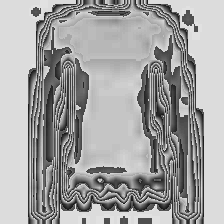

Target:  pullover
Guess:  pullover


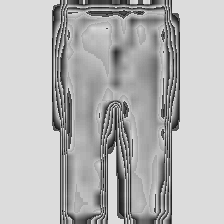

Target:  trouser
Guess:  trouser


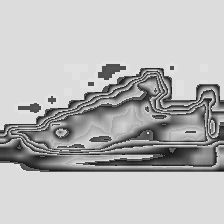

Target:  sneaker
Guess:  sneaker


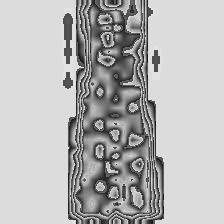

Target:  dress
Guess:  dress


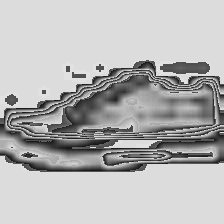

Target:  sneaker
Guess:  sneaker


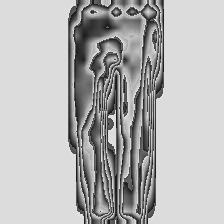

Target:  trouser
Guess:  trouser


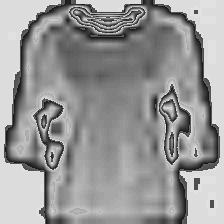

Target:  shirt
Guess:  shirt


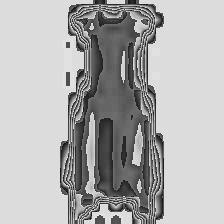

Target:  dress
Guess:  dress


In [12]:
eval_network(net, test_loader)

正确率已经达到了81.95%！